In [3]:
## Standard libraries
import numpy as np

## Imports for plotting
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

## PyTorch
import torch

## Torchvision
import torchvision
from torchvision.datasets import SVHN, MNIST, USPS
import torchvision.transforms as T
from torch.utils.data import DataLoader

## Sklearn
from sklearn.manifold import TSNE

## UMAP
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
  print("Using Google Colab")
  !pip install umap-learn
  from umap import UMAP
else:
  from umap import UMAP

# Path to the folder where the datasets are/should be downloaded
DATASET_PATH = "./data"

Using Google Colab


In [4]:
print("Using torch", torch.__version__)

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print ("MPS (MacBook) device found.")
    #print('Number of MPS cards: ', torch.mps.device_count())
    #print('Total MPS memory {0:.2f} GB'.format(torch.mps.recommended_max_memory()/pow(10,9)))
elif torch.backends.cuda.is_built():
    device = torch.device("cuda")
    # Ensure that all operations are deterministic on GPU (if used) for reproducibility
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print ("CUDA device found.")
    print('Number of GPU cards: ', torch.cuda.device_count(), '\nWhich card GPU?', torch.cuda.get_device_name(0))
    print('Total GPU memory {1:.2f} GB. Free GPU memory {0:.2f} GB'.format(torch.cuda.mem_get_info()[0]/pow(10,9),torch.cuda.mem_get_info()[1]/pow(10,9)))
else:
   device = torch.device("cpu")
   print('No MPS or CUDA has been found. PyTorch will use CPU.')

Using torch 2.5.1+cu124
CUDA device found.
Number of GPU cards:  1 
Which card GPU? Tesla T4
Total GPU memory 15.83 GB. Free GPU memory 15.72 GB


In [5]:
!lspci | grep -i nvidia

/bin/bash: line 1: lspci: command not found


In this practical session you will implement and test the method presented in [1] for Unsupervised Domain Adaptation.

You will use three imaging datasets showing 0-9 digits: MNIST, SVHN and USPS.

We know that the output spaces are equal (same labels/classes), namely the digits from 0 to 9, and we will resize the data so that the input spaces are also equal (same number of pixels per image).

In this TP, you will assume a covariate shift and therefore that there is a shift between the marginal disitributions $p_S(X)$ and $p_T(X)$ and that the conditionl distributions $p_S(Y|X)$ and $p_t(Y|X)$ are equal.

As for the other TP, answer all questions and fill the code where you see **XXXXXXXXX**

**Deadline**: please verify on the Moodle/Ecampus the deadline



[1] B. Fernando et al. “Unsupervised Visual Domain Adaptation Using Subspace Alignment”. In: ICCV. 2013.

### **MNIST**

 Let's start by downloading the **MNIST** dataset: a very common and large database of grayscale images showing handwritten digits ranging from 0 to 9. It comprises 60,000 training images and 10,000 testing images of size 28x28.

To cope with the assumption about the "same number of input pixels per image", we choose the input dimension of 32x32 for all datasets. We thus resize all images (originally 28x28) using the padding function "Pad" (add 0 to the borders).


In [6]:
# Transform to normalized Tensors in the range [0,1]
MNIST_train_dataset = MNIST(root=DATASET_PATH, train= True, download=True, transform=T.Compose([T.Pad(2), T.ToTensor()]))
MNIST_test_dataset = MNIST(root=DATASET_PATH, train= False, download=True, transform=T.Compose([T.Pad(2), T.ToTensor()]))

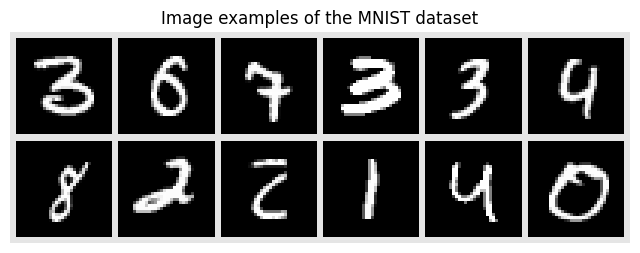

In [7]:
# Visualize some examples
NUM_IMAGES = 12
MNIST_images = torch.stack([MNIST_train_dataset[np.random.randint(len(MNIST_train_dataset))][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(MNIST_images, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Image examples of the MNIST dataset")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

Be careful ! Even if you put a transform when downloading the data and creating teh Pytorch Dataset, this is actually not applied until you load the data with a DataLoader.

For instance, when you load images in the range $[0,255]$ and you put the transform `ToTensor()`, this should automatically normalize the images in the range $[0,1]$ and transform them into Pytorch tensors. However, if you simply take the data from the DataSet *WITHOUT* the DataLoader...

In [8]:
#This does not apply the normalization to [0-1] (transform To.Tensor() )
MNIST_Xtrain_255 = MNIST_train_dataset.data.numpy()
MNIST_ytrain_255 = MNIST_train_dataset.targets.numpy()


In [9]:
print(MNIST_Xtrain_255.shape)
print(MNIST_ytrain_255.shape)

print('Min Pixel Value: {} \nMax Pixel Value: {}'.format(MNIST_Xtrain_255.min(), MNIST_Xtrain_255.max()))
print('Mean Pixel Value {} \nPixel Values Std: {}'.format(MNIST_Xtrain_255.mean(), MNIST_Xtrain_255.std()))
print('Min Pixel Value: {} \nMax Pixel Value: {}'.format(MNIST_Xtrain_255.min(), MNIST_Xtrain_255.max()))

(60000, 28, 28)
(60000,)
Min Pixel Value: 0 
Max Pixel Value: 255
Mean Pixel Value 33.318421449829934 
Pixel Values Std: 78.56748998339798
Min Pixel Value: 0 
Max Pixel Value: 255


Instead, if we load them with the Dataloader...

In [10]:
MNIST_train_loader = DataLoader(MNIST_train_dataset, batch_size=len(MNIST_train_dataset))
MNIST_test_loader = DataLoader(MNIST_test_dataset, batch_size=len(MNIST_test_dataset))

MNIST_Xtrain_ima = np.squeeze(next(iter(MNIST_train_loader))[0].numpy())
MNIST_ytrain = next(iter(MNIST_train_loader))[1].numpy()

MNIST_Xtest_ima = np.squeeze(next(iter(MNIST_test_loader))[0].numpy())
MNIST_ytest = next(iter(MNIST_test_loader))[1].numpy()


In [11]:
print(MNIST_Xtrain_ima.shape)
print(MNIST_ytrain.shape)

print(MNIST_Xtest_ima.shape)
print(MNIST_ytest.shape)

print('Min Pixel Value: {} \nMax Pixel Value: {}'.format(MNIST_Xtrain_ima.min(), MNIST_Xtrain_ima.max()))
print('Mean Pixel Value {} \nPixel Values Std: {}'.format(MNIST_Xtrain_ima.mean(), MNIST_Xtrain_ima.std()))

print('Min Pixel Value: {} \nMax Pixel Value: {}'.format(MNIST_Xtest_ima.min(), MNIST_Xtest_ima.max()))
print('Mean Pixel Value {} \nPixel Values Std: {}'.format(MNIST_Xtest_ima.mean(), MNIST_Xtest_ima.std()))

(60000, 32, 32)
(60000,)
(10000, 32, 32)
(10000,)
Min Pixel Value: 0.0 
Max Pixel Value: 1.0
Mean Pixel Value 0.10003671795129776 
Pixel Values Std: 0.2752174437046051
Min Pixel Value: 0.0 
Max Pixel Value: 1.0
Mean Pixel Value 0.10145653039216995 
Pixel Values Std: 0.2774091958999634


(12, 32, 32)


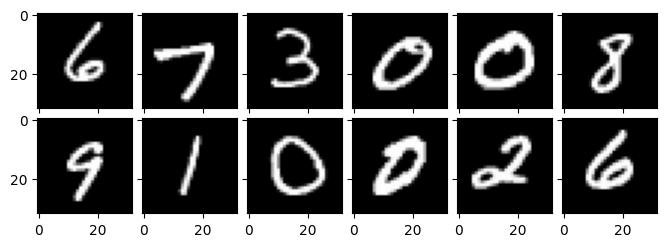

In [12]:
from mpl_toolkits.axes_grid1 import ImageGrid

NUM_IMAGES=12
MNIST_grid = MNIST_Xtrain_ima[np.random.randint(0,len(MNIST_Xtrain_ima),12),:,:]
print(MNIST_grid.shape)

fig = plt.figure(figsize=(8,8))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 6),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, MNIST_grid):
    # Iterating over the grid returns the Axes.
    ax.imshow(im,cmap='gray')

plt.show()

So we have 60k training images and 10K test images of size $[32 x 32]$. Let's load another dataset

### **SVHN dataset**

The Street View House Numbers (SVHN) dataset is a real-world image dataset for house number detection. It is similar to MNIST since it has the same digit classes (0 to 9), but it is significantly harder due to its real-world setting. SVHN is obtained from house numbers in Google Street View images.

It comprises RGB images of size $32x32$

We change them from RGB to grayscale to compare them with the MNIST images.


In [13]:
SVHN_train_dataset = SVHN(root=DATASET_PATH, split='train', download=True, transform=T.Compose([T.Grayscale(), T.ToTensor()]))
SVHN_test_dataset = SVHN(root=DATASET_PATH, split='test', download=True, transform=T.Compose([T.Grayscale(), T.ToTensor()]))

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat


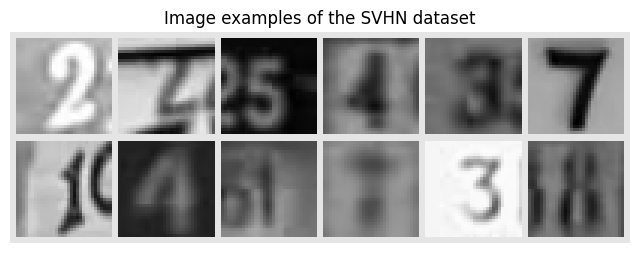

In [14]:
# Visualize some examples
NUM_IMAGES = 12
SVHN_images = torch.stack([SVHN_test_dataset[np.random.randint(len(SVHN_test_dataset))][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(SVHN_images, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Image examples of the SVHN dataset")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

In [15]:
SVHN_train_loader = DataLoader(SVHN_train_dataset, batch_size=len(SVHN_train_dataset))
SVHN_test_loader = DataLoader(SVHN_test_dataset, batch_size=len(SVHN_test_dataset))

SVHN_Xtrain_ima = np.squeeze(next(iter(SVHN_train_loader))[0].numpy())
SVHN_ytrain = next(iter(SVHN_train_loader))[1].numpy()

SVHN_Xtest_ima = np.squeeze(next(iter(SVHN_test_loader))[0].numpy())
SVHN_ytest = next(iter(SVHN_test_loader))[1].numpy()


In [16]:
print(SVHN_Xtrain_ima.shape)
print(SVHN_ytrain.shape)
print(SVHN_Xtest_ima.shape)
print(SVHN_ytest.shape)

print('Min Pixel Value: {} \nMax Pixel Value: {}'.format(SVHN_Xtrain_ima.min(), SVHN_Xtrain_ima.max()))
print('Mean Pixel Value {} \nPixel Values Std: {}'.format(SVHN_Xtrain_ima.mean(), SVHN_Xtrain_ima.std()))

print('Min Pixel Value: {} \nMax Pixel Value: {}'.format(SVHN_Xtest_ima.min(), SVHN_Xtest_ima.max()))
print('Mean Pixel Value {} \nPixel Values Std: {}'.format(SVHN_Xtest_ima.mean(), SVHN_Xtest_ima.std()))

(73257, 32, 32)
(73257,)
(26032, 32, 32)
(26032,)
Min Pixel Value: 0.0 
Max Pixel Value: 1.0
Mean Pixel Value 0.4452594220638275 
Pixel Values Std: 0.196975976228714
Min Pixel Value: 0.0 
Max Pixel Value: 1.0
Mean Pixel Value 0.45435550808906555 
Pixel Values Std: 0.2220025360584259


Here we have ~73K training images and ~26K test images of the same size $[32 x x32]$

### **USPS**

As last dataset, we will use the USPS dataset which contains images of digits (from 0 to 9) scanned from envelopes by the U.S. Postal Service. It contains a total of 9,298 $16x16$ pixel grayscale images. Images are centered, normalized and show a broad range of font styles.

Even in ths case, we pad them with 0 in order to have $32 x 32$ images.

In [17]:
USPS_train_dataset = USPS(root=DATASET_PATH, train= True, download=True, transform=T.Compose([T.Pad(8), T.ToTensor()]))
USPS_test_dataset = USPS(root=DATASET_PATH, train= False, download=True, transform=T.Compose([T.Pad(8), T.ToTensor()]))

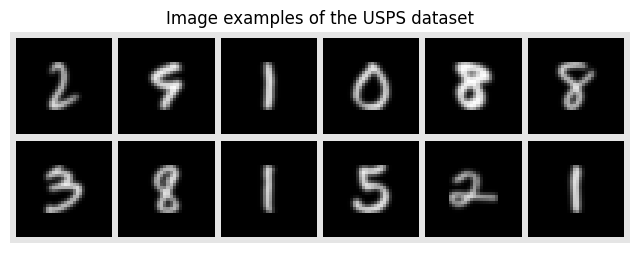

In [18]:
# Visualize some examples
NUM_IMAGES = 12
USPS_images = torch.stack([USPS_train_dataset[np.random.randint(len(USPS_train_dataset))][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(USPS_images, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Image examples of the USPS dataset")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

In [19]:
USPS_train_loader = DataLoader(USPS_train_dataset, batch_size=len(USPS_train_dataset))
USPS_test_loader = DataLoader(USPS_test_dataset, batch_size=len(USPS_test_dataset))

USPS_Xtrain_ima = np.squeeze(next(iter(USPS_train_loader))[0].numpy())
USPS_ytrain = next(iter(USPS_train_loader))[1].numpy()

USPS_Xtest_ima = np.squeeze(next(iter(USPS_test_loader))[0].numpy())
USPS_ytest = next(iter(USPS_test_loader))[1].numpy()

In [20]:
print(USPS_Xtrain_ima.shape)
print(USPS_ytrain.shape)
print(USPS_Xtest_ima.shape)
print(USPS_ytest.shape)

print('Min Pixel Value: {} \nMax Pixel Value: {}'.format(USPS_Xtrain_ima.min(), USPS_Xtrain_ima.max()))
print('Mean Pixel Value {} \nPixel Values Std: {}'.format(USPS_Xtrain_ima.mean(), USPS_Xtrain_ima.std()))

print('Min Pixel Value: {} \nMax Pixel Value: {}'.format(USPS_Xtest_ima.min(), USPS_Xtest_ima.max()))
print('Mean Pixel Value {} \nPixel Values Std: {}'.format(USPS_Xtest_ima.mean(), USPS_Xtest_ima.std()))

(7291, 32, 32)
(7291,)
(2007, 32, 32)
(2007,)
Min Pixel Value: 0.0 
Max Pixel Value: 0.9960784316062927
Mean Pixel Value 0.06171923503279686 
Pixel Values Std: 0.18373751640319824
Min Pixel Value: 0.0 
Max Pixel Value: 1.0
Mean Pixel Value 0.06497029960155487 
Pixel Values Std: 0.19083774089813232


We have ~7K training images and ~2k test images of size $[32 x 32]$

### **UMAP**

One of the first things to do, is to visually check the data to verify if it exists a domain gap and if the datasets are different.

Here, we will use the UMAP and t-SNE methods which are general manifold learning and non-linear dimension reduction algorithms (probably the two most-used ones). UMAP can be seen as a Riemannian extension of the t-SNE method (which uses an Euclidean distance).

[1] Leland McInnes, John Healy, James Melville. "UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction". 2018

[2] van der Maaten, L.J.P., Hinton, G.E. "Visualizing Data Using t-SNE". Journal of Machine Learning Research. 2008


Transform data so that instead than having 3D arrays of images we will have 2D arrays by vectorizing each image -> 32 x 32 = 1024

In [21]:
# MNIST
MNIST_Xtrain=MNIST_Xtrain_ima.reshape(MNIST_Xtrain_ima.shape[0], -1)
MNIST_Xtest=MNIST_Xtest_ima.reshape(MNIST_Xtest_ima.shape[0], -1)

print(MNIST_Xtrain.shape, MNIST_Xtest.shape)

# USPS
USPS_Xtrain=USPS_Xtrain_ima.reshape(USPS_Xtrain_ima.shape[0], -1)
USPS_Xtest=USPS_Xtest_ima.reshape(USPS_Xtest_ima.shape[0], -1)

print(USPS_Xtrain.shape, USPS_Xtest.shape)

# SVHN
SVHN_Xtrain=SVHN_Xtrain_ima.reshape(SVHN_Xtrain_ima.shape[0], -1)
SVHN_Xtest=SVHN_Xtest_ima.reshape(SVHN_Xtest_ima.shape[0], -1)

print(SVHN_Xtrain.shape, SVHN_Xtest.shape)

(60000, 1024) (10000, 1024)
(7291, 1024) (2007, 1024)
(73257, 1024) (26032, 1024)


Here, we randomly pick only 1000 samples per dataset for visualization and to reduce the computational burden.

In [22]:
# Reduced MNIST
np.random.seed(42)
MNIST_indices = np.random.choice(MNIST_Xtrain.shape[0], 1000, replace=False)
MNIST_Xtrain_res = MNIST_Xtrain[MNIST_indices]
MNIST_ytrain_res = MNIST_ytrain[MNIST_indices]

# Reduced USPS
USPS_indices = np.random.choice(USPS_Xtrain.shape[0], 1000, replace=False)
USPS_Xtrain_res = USPS_Xtrain[USPS_indices]
USPS_ytrain_res = USPS_ytrain[USPS_indices]

# Reduced SVHN
SVHN_indices = np.random.choice(SVHN_Xtrain.shape[0], 1000, replace=False)

SVHN_Xtrain_res = SVHN_Xtrain[SVHN_indices]
SVHN_ytrain_res = SVHN_ytrain[SVHN_indices]


# Reduced Data
xtot=np.concatenate((MNIST_Xtrain_res,USPS_Xtrain_res,SVHN_Xtrain_res),axis=0) # all data
nMNIST=MNIST_Xtrain_res.shape[0]
nUSPS=USPS_Xtrain_res.shape[0]
nSVHN=SVHN_Xtrain_res.shape[0]



In [23]:
xp = UMAP().fit_transform(xtot) # this should take ~50sec

print(xp.shape)

# separate again but now in 2D
xpMNIST=xp[:nMNIST,:]
xpUSPS=xp[nMNIST:nMNIST+nUSPS,:]
xpSVHN=xp[nMNIST+nUSPS:,:]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


(3000, 2)


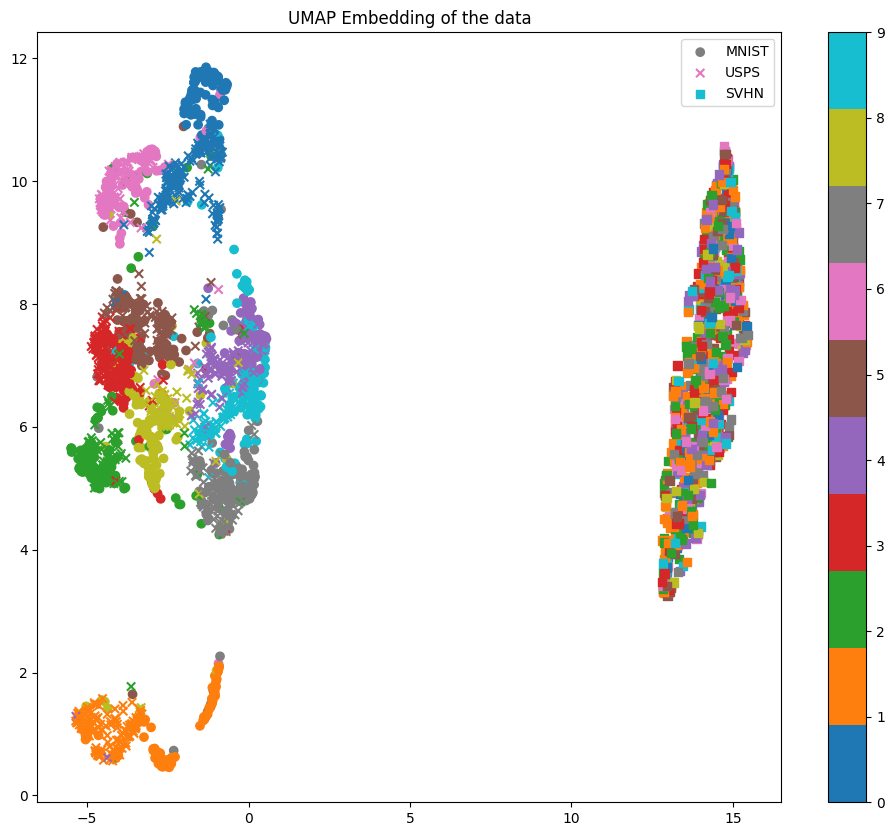

In [24]:
plt.figure(3,(12,10))

plt.scatter(xpMNIST[:,0],xpMNIST[:,1],c=MNIST_ytrain_res,marker='o',cmap='tab10',label='MNIST')
plt.scatter(xpUSPS[:,0],xpUSPS[:,1],c=USPS_ytrain_res,marker='x',cmap='tab10',label='USPS')
plt.scatter(xpSVHN[:,0],xpSVHN[:,1],c=SVHN_ytrain_res,marker='s',cmap='tab10',label='SVHN')
plt.legend()
plt.colorbar()
plt.title('UMAP Embedding of the data')
plt.show()

It seems that one dataset is quite different from the other two.

**Question**: What are your conclusions ? Re-run the code showing only the most similar datasets.

The UMAP embedding shows clear clustering for MNIST and USPS, with distinct class boundaries reflecting their handwritten digit similarity. In contrast, the SVHN dataset forms a dense, overlapping cluster, highlighting the complexity of real-world images. This illustrates UMAP’s strength in preserving local structures while revealing challenges in separating more complex data.

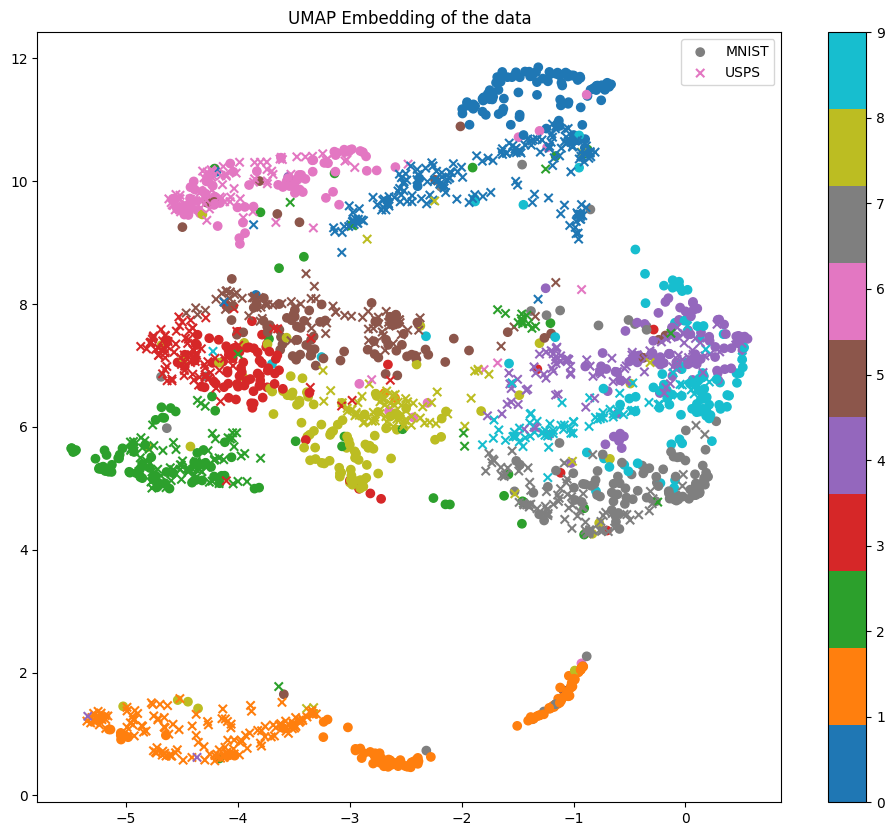

In [25]:
plt.figure(3,(12,10))

plt.scatter(xpMNIST[:,0],xpMNIST[:,1],c=MNIST_ytrain_res,marker='o',cmap='tab10',label='MNIST')
plt.scatter(xpUSPS[:,0],xpUSPS[:,1],c=USPS_ytrain_res,marker='x',cmap='tab10',label='USPS')
plt.legend()
plt.colorbar()
plt.title('UMAP Embedding of the data')
plt.show()

**Question**: Can you see a domain shift between the datasets ?


The UMAP embedding reveals a moderate domain shift between MNIST and USPS. While there is noticeable overlap in many clusters, indicating shared feature representations, certain classes show distinct separations with denser MNIST clusters and more dispersed USPS points. This suggests differences in data characteristics, such as handwriting styles and preprocessing, which could impact model generalization across the two datasets.

Now we can test the t-SNE algorithm to check whether your conclusions are confirmed.

In [26]:
%time xp=TSNE().fit_transform(xtot) # this should take around 50 sec

print(xp.shape)

# separate again but now in 2D
xpMNIST=xp[:nMNIST,:]
xpUSPS=xp[nMNIST:nMNIST+nUSPS,:]
xpSVHN=xp[nMNIST+nUSPS:,:]
print(xpMNIST.shape,xpUSPS.shape,xpSVHN.shape)

CPU times: user 25.7 s, sys: 170 ms, total: 25.9 s
Wall time: 25.7 s
(3000, 2)
(1000, 2) (1000, 2) (1000, 2)


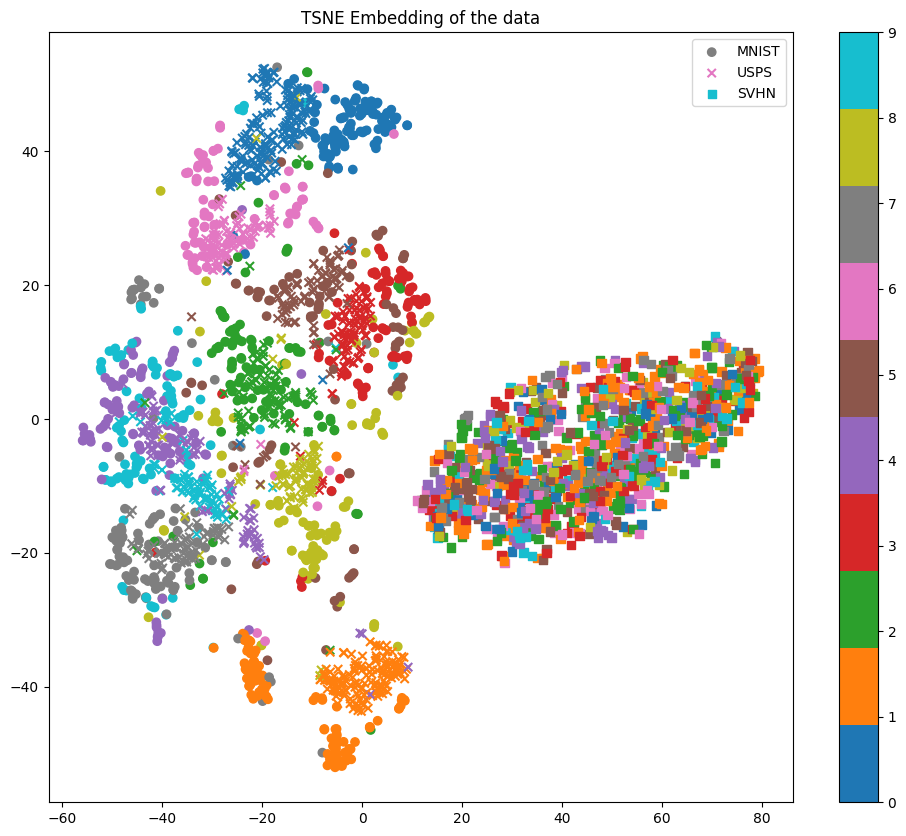

In [27]:
plt.figure(3,(12,10))

plt.scatter(xpMNIST[:,0],xpMNIST[:,1],c=MNIST_ytrain_res,marker='o',cmap='tab10',label='MNIST')
plt.scatter(xpUSPS[:,0],xpUSPS[:,1],c=USPS_ytrain_res,marker='x',cmap='tab10',label='USPS')
plt.scatter(xpSVHN[:,0],xpSVHN[:,1],c=SVHN_ytrain_res,marker='s',cmap='tab10',label='SVHN')
plt.legend()
plt.colorbar()
plt.title('TSNE Embedding of the data')
plt.show()

**Question**: can you confirm your previous conclusions ?

Yes. The t-SNE embedding confirms a moderate domain shift between MNIST and USPS, with overlapping clusters but noticeable dataset-specific regions. SVHN forms a distinct, dense cluster, clearly separated from the handwritten datasets, highlighting a significant domain shift due to its real-world image complexity. This reinforces the challenges of cross-domain generalization observed earlier.

It seems that one dataset is quite different from the other two data-sets.

**Question**: Analyse that dataset alone using UMAP (faster)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


(3000, 2)


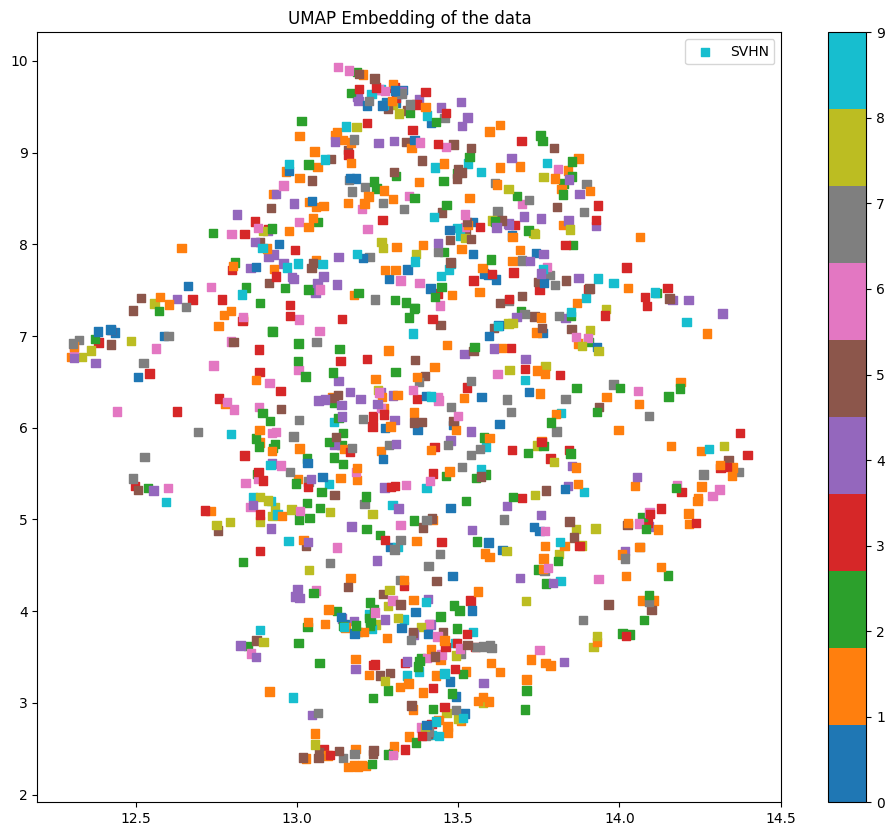

In [28]:
xp=UMAP().fit_transform(xtot) # this should take ~50sec

print(xp.shape)


xpSVHN=xp[nMNIST+nUSPS:,:]

plt.figure(3,(12,10))

plt.scatter(xpSVHN[:,0],xpSVHN[:,1],c=SVHN_ytrain_res,marker='s',cmap='tab10',label='SVHN')
plt.legend()
plt.colorbar()
plt.title('UMAP Embedding of the data')
plt.show()

**Question**: Are the data clearly clustered and well separated as for the other two datasets ? If not, why is that in your opinion ?

Hint: think about the input space of UMAP...

The SVHN data in this UMAP embedding are not clearly clustered or well-separated, unlike MNIST and USPS. This is due to SVHN's complex, real-world images with high variability in backgrounds, lighting, and digit styles, which challenges UMAP’s ability to capture distinct local structures. Additionally, UMAP struggles with SVHN’s high-dimensional, diverse input space, where feature distances are less informative compared to the simpler, more uniform handwritten digits.

# Unsupervised Domain Adaptation

The three data-sets have the same features $\mathcal{X}$ (all images have size $[32 x 32]$)
 and the same classes (output labels) $\mathcal{Y}$ but they have different marginal $p(X)$ distributions.

In this part, we will assume that we only have labeled data in the source domain $S$ but not int the target domain $T$. By matching the source $p_S(X)$ and target $p_T(X)$ marginal distributions, one can hope that a classifier learnt on $S$ will also work on $T$.

Here, you will implement and test the following algorithm based on subspace alignement:

B. Fernando et al. "*Unsupervised Visual Domain Adaptation Using Subspace Alignment*". ICCV, 2013.

The first thing to do is to choose the source domain and the target domain.
Let's start with the MNIST dataset as source and USPS as target.

We will use the previousyly computed reduced datasets to speed up computations.

In [66]:
# Source domain
XtrainS = MNIST_Xtrain_res
ytrainS = MNIST_ytrain_res
XtestS = MNIST_Xtest
ytestS = MNIST_ytest

# # Target domain
XtrainT = USPS_Xtrain_res
ytrainT = USPS_ytrain_res
XtestT = USPS_Xtest
ytestT = USPS_ytest

# Target domain
# XtrainT = SVHN_Xtrain_res
# ytrainT = SVHN_ytrain_res
# XtestT = SVHN_Xtest
# ytestT = SVHN_ytest

Ns=1000 # number of samples in source domain
Nt=1000 # number of samples in target domain

Implement the method following the description of the method in the slides of the lecture (around slide 75).  

In [30]:
from sklearn.decomposition import PCA

def SA(XTrainS,XTestS,XTrainT,XTestT,d=10):
  """
  Subspace Alignment (SA)

  Input
  XTrainS : Input training source data [NTrS,D]
  XTestS : Input test source data [NTeS,D]
  XTrainT : Input training target data [NTrT,D]
  XTestT : Input test target data [NTeT,D]
  d : number of PCA components

  Output
  XTrainSp : projected and transformed source training data [NTrS,d]
  XTestSp : projected and transformed source test data [NTeS,d]
  XTrainTp : projected training target data [NTrT,d]
  XTestTp : projected test target data [NTeT,d]
  """

  pca_S = PCA(n_components=d)
  pca_T = PCA(n_components=d)

  pca_S.fit(XTrainS)
  pca_T.fit(XTrainT)

  U_S = pca_S.components_.T
  U_T = pca_T.components_.T

  M = np.dot(U_S.T, U_T)

  XTrainSp = np.dot(XTrainS, U_S).dot(M)
  XTestSp = np.dot(XTestS, U_S).dot(M)

  XTrainTp = np.dot(XTrainT, U_T)
  XTestTp = np.dot(XTestT, U_T)

  return XTrainSp,XTestSp,XTrainTp,XTestTp


We start by veryfying the score of a classifier trained on the source domain and tested on the target domain (no adaptation).

You can use the classifier you want (e.g., logistic regression, SVM, ...)

In [31]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

np.random.seed(42)
svm_clf = SVC(kernel='linear')
svm_clf.fit(XtrainS, ytrainS)
y_predT = svm_clf.predict(XtestT)
accuracy = accuracy_score(ytestT, y_predT)
print(f"Accuracy of classifier on target domain (without adaptation): {accuracy:.4f}")

Accuracy of classifier on target domain (without adaptation): 0.5805


To reduce dimensionality, we can also first compute PCA using the source training set and then project (i.e., transform) all data (source and target, training and test) on the first $d$ components.

**Question**: try different values of $d$. Is there a difference with the previous full-training data appraoch ?

In [32]:
np.random.seed(42)
for d in [10, 20, 30, 50, 100, 200]:
  svm_clf_pca = SVC(kernel='linear')
  pca = PCA(n_components=d)
  XtrainS_pca = pca.fit_transform(XtrainS)
  XtestT_pca = pca.transform(XtestT)
  svm_clf_pca.fit(XtrainS_pca, ytrainS)
  y_predT_pca = svm_clf_pca.predict(XtestT_pca)
  accuracy_pca = accuracy_score(ytestT, y_predT_pca)
  print(f"Accuracy with PCA (d={d}): {accuracy_pca:.4f}")

Accuracy with PCA (d=10): 0.5341
Accuracy with PCA (d=20): 0.5247
Accuracy with PCA (d=30): 0.5481
Accuracy with PCA (d=50): 0.5615
Accuracy with PCA (d=100): 0.5855
Accuracy with PCA (d=200): 0.5805


Using PCA with fewer components resulted in lower accuracy. However, when the number of components was increased to d = 100, the accuracy slightly improved to 0.5855, which is just marginally higher than the accuracy achieved with the full training data (0.5805).

We can now test the SA approach.

**Question**: try different values of $d$. Does the performance improve on the target domain ? Try at least two different ML methods (one linear and one non-linear) and one DL architecture (it can be a pre-trained model or a simple architecture). What's the best ?

In [69]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Define the SVM model function (linear kernel)
def svm_classifier(Xtrain, ytrain, Xtest):
    clf = SVC(kernel='linear')  # Linear kernel SVM
    clf.fit(Xtrain, ytrain)
    y_pred = clf.predict(Xtest)
    return accuracy_score(ytestT, y_pred)

# Define the non-linear SVM (RBF kernel)
def svm_rbf_classifier(Xtrain, ytrain, Xtest):
    clf = SVC(kernel='rbf')  # Non-linear SVM with RBF kernel
    clf.fit(Xtrain, ytrain)
    y_pred = clf.predict(Xtest)
    return accuracy_score(ytestT, y_pred)

# Define a simple neural network for classification
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)  # Assuming 10 classes
        )

    def forward(self, x):
        return self.model(x)

# Neural Network training function
def train_nn(model, optimizer, criterion, Xtrain, ytrain, Xtest, ytest, epochs=100):
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(Xtrain)
        loss = criterion(outputs, ytrain)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        outputs = model(Xtest)
        _, predicted = torch.max(outputs, 1)
        accuracy = accuracy_score(ytest.numpy(), predicted.numpy())
    return accuracy

# Initialize best accuracy to track the best performing model
best_accuracy = 0
best_d = 0
best_model = None
best_method = ""

d_values = [10, 50, 100]

# Loop through different values of d to apply Subspace Alignment (SA)
for d in d_values:
    XTrainSp, XTestSp, XTrainTp, XTestTp = SA(XtrainS, XtestS, XtrainT, XtestT, d=d)

    # Train and evaluate using SVM with linear kernel
    accuracy_svm = svm_classifier(XTrainSp, ytrainS, XTestTp)

    # Train and evaluate using SVM with RBF kernel
    accuracy_svm_rbf = svm_rbf_classifier(XTrainSp, ytrainS, XTestTp)

    # Train and evaluate using the neural network
    model = SimpleNN(d)  # Use d as the input dimension
    optimizer = optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss()

    # Convert data to tensor
    XTrainTp_tensor = torch.tensor(XTrainTp, dtype=torch.float32)
    ytrainS_tensor = torch.tensor(ytrainS, dtype=torch.long)
    XTestTp_tensor = torch.tensor(XTestTp, dtype=torch.float32)
    ytestT_tensor = torch.tensor(ytestT, dtype=torch.long)

    # Train the model
    for epoch in range(100):
        optimizer.zero_grad()
        outputs = model(XTrainTp_tensor)
        loss = criterion(outputs, ytrainS_tensor)
        loss.backward()
        optimizer.step()

    # Evaluate the model
    with torch.no_grad():
        outputs = model(XTestTp_tensor)
        _, predicted = torch.max(outputs, 1)
        accuracy_nn = accuracy_score(ytestT, predicted.numpy())

    # Display results for current d
    print(f"Results for d={d}:")
    print(f"SVM (linear): {accuracy_svm:.4f}")
    print(f"SVM (RBF): {accuracy_svm_rbf:.4f}")
    print(f"Neural Network: {accuracy_nn:.4f}")
    print()

    # Track the best model
    if accuracy_svm > best_accuracy:
        best_accuracy = accuracy_svm
        best_d = d
        best_model = "SVM (linear)"


    if accuracy_svm_rbf > best_accuracy:
        best_accuracy = accuracy_svm_rbf
        best_d = d
        best_model = "SVM (RBF)"


    if accuracy_nn > best_accuracy:
        best_accuracy = accuracy_nn
        best_d = d
        best_model = "Neural Network"


# Output the best model and its performance
print(f"Best model: {best_model} with d={best_d}, Accuracy: {best_accuracy:.4f}")


Results for d=10:
SVM (linear): 0.5665
SVM (RBF): 0.6114
Neural Network: 0.0817

Results for d=50:
SVM (linear): 0.6243
SVM (RBF): 0.6587
Neural Network: 0.0817

Results for d=100:
SVM (linear): 0.6662
SVM (RBF): 0.6592
Neural Network: 0.0917

Best model: SVM (linear) with d=100, Accuracy: 0.6662


The results show how varying the dimensionality (d) after Subspace Alignment (SA) affects performance across different models:

- SVM (Linear):
Performance improves consistently as d increases, peaking at 66.62% accuracy with d=100.
This suggests that higher dimensions retain more discriminative features, which linear models effectively exploit after domain alignment.

- SVM (RBF - Non-linear):
Shows strong performance with 61.14% at d=10, improving to 65.92% at d=100.
However, unlike the linear SVM, the performance plateaus between d = 50 and d = 100, indicating that non-linear models like RBF SVM may capture relevant patterns even in lower dimensions.

- Neural Network (Deep Learning):
Performance remains consistently low (~8-9%), suggesting that the architecture struggles to generalize well, possibly due to insufficient data, inadequate model complexity, or lack of proper tuning (like regularization, learning rate adjustments, or deeper architectures).


The linear SVM with d=100 achieves the highest accuracy (66.62%), outperforming both the non-linear SVM and the neural network.
After SA, the data is likely well-aligned and linearly separable, making linear models more effective.

**Question**: Use the UMAP or t-SNE visualization to check whether the data are more similar after the SA adaptation. What can you conclude ?

In [34]:
XTrainSp, XTestSp, XTrainTp, XTestTp = SA(XtrainS, XtestS, XtrainT, XtestT, d=100)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


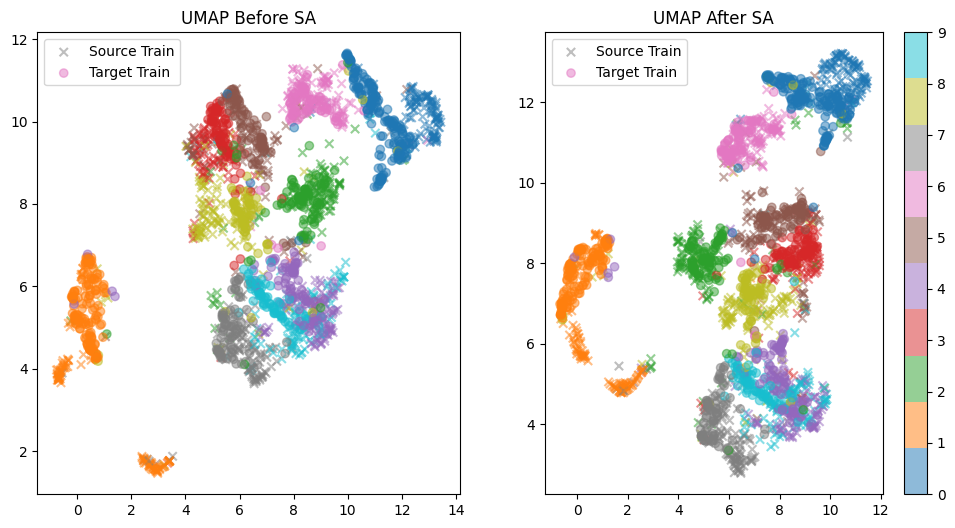

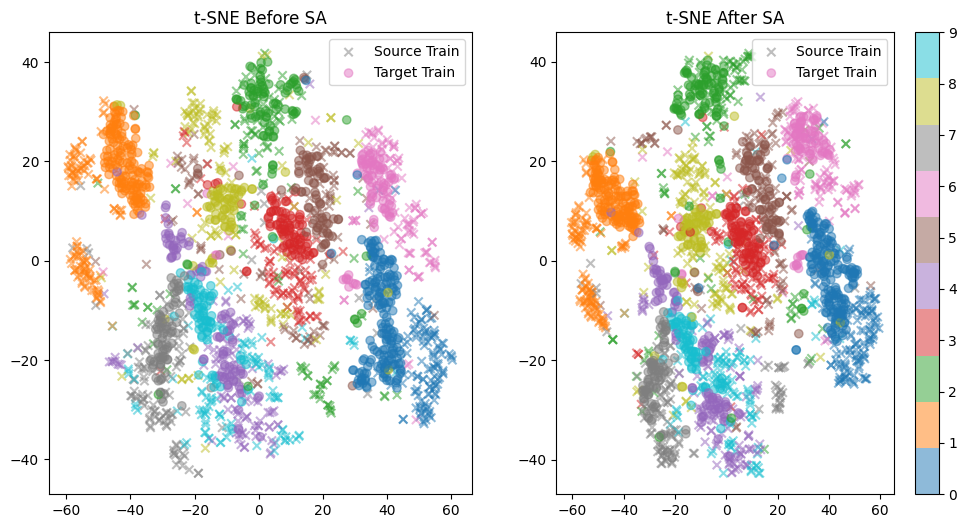

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from umap import UMAP
from sklearn.manifold import TSNE
import numpy as np


# Visualization function
def plot_umap_tsne(XTrainS, XTrainT, XTrainSp, XTrainTp, yTrainS, yTrainT):
    np.random.seed(42)

    umap_model = UMAP()
    umap_before = umap_model.fit_transform(np.concatenate((XTrainS, XTrainT), axis=0))
    umap_after = umap_model.fit_transform(np.concatenate((XTrainSp, XTrainTp), axis=0))

    tsne_model = TSNE()
    tsne_before = tsne_model.fit_transform(np.concatenate((XTrainS, XTrainT), axis=0))
    tsne_after = tsne_model.fit_transform(np.concatenate((XTrainSp, XTrainTp), axis=0))

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(umap_before[:len(XTrainS), 0], umap_before[:len(XTrainS), 1], c=yTrainS, marker='x', cmap='tab10', label='Source Train', alpha=0.5)
    plt.scatter(umap_before[len(XTrainS):, 0], umap_before[len(XTrainS):, 1], c=yTrainT, marker='o', cmap='tab10', label='Target Train', alpha=0.5)
    plt.title("UMAP Before SA")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.scatter(umap_after[:len(XTrainSp), 0], umap_after[:len(XTrainSp), 1], c=yTrainS, marker='x', cmap='tab10', label='Source Train', alpha=0.5)
    plt.scatter(umap_after[len(XTrainSp):, 0], umap_after[len(XTrainSp):, 1], c=yTrainT, marker='o', cmap='tab10', label='Target Train', alpha=0.5)
    plt.title("UMAP After SA")
    plt.legend()
    plt.colorbar()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(tsne_before[:len(XTrainS), 0], tsne_before[:len(XTrainS), 1], c=yTrainS, marker='x', cmap='tab10', label='Source Train', alpha=0.5)
    plt.scatter(tsne_before[len(XTrainS):, 0], tsne_before[len(XTrainS):, 1], c=yTrainT, marker='o', cmap='tab10', label='Target Train', alpha=0.5)
    plt.title("t-SNE Before SA")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.scatter(tsne_after[:len(XTrainSp), 0], tsne_after[:len(XTrainSp), 1], c=yTrainS, marker='x', cmap='tab10', label='Source Train', alpha=0.5)
    plt.scatter(tsne_after[len(XTrainSp):, 0], tsne_after[len(XTrainSp):, 1], c=yTrainT, marker='o', cmap='tab10', label='Target Train', alpha=0.5)
    plt.title("t-SNE After SA")
    plt.legend()
    plt.colorbar()

    plt.show()

# Plot UMAP and t-SNE visualizations
plot_umap_tsne(XtrainS, XtrainT, XTrainSp, XTrainTp, ytrainS, ytrainT)

- Before SA: The source and target data are clearly separated, with noticeable gaps and limited overlap between domains. This indicates a significant domain shift, making it challenging for models trained on the source domain to generalize to the target domain.

- After SA: There is greater overlap and alignment between the source and target data. The clusters are more intermixed, suggesting that SA has successfully reduced the domain shift by aligning the feature spaces of both datasets.

Subspace Alignment has made the source and target domains more similar, facilitating better knowledge transfer and improving the performance of domain adaptation models.

**Question**: Repeat the same experiments for different Source and Target domains. Use at least the two followng configurations:

Source: MNIST, Target: USPS

Source MNIST, Target: SVHN

**Queston**: Comment the results

In [55]:
# Source domain
XtrainS = MNIST_Xtrain
ytrainS = MNIST_ytrain
XtestS = MNIST_Xtest
ytestS = MNIST_ytest

# # Target domain
XtrainT = USPS_Xtrain
ytrainT = USPS_ytrain
XtestT = USPS_Xtest
ytestT = USPS_ytest

Ns=1000 # number of samples in source domain
Nt=1000 # number of samples in target domain

In [56]:
np.random.seed(42)
for d in [10, 20, 30, 50, 100, 200]:
  svm_classifier_pca = SVC(kernel='linear')
  pca = PCA(n_components=d)
  XtrainS_pca = pca.fit_transform(XtrainS)
  XtestT_pca = pca.transform(XtestT)
  svm_classifier_pca.fit(XtrainS_pca, ytrainS)
  y_predT_pca = svm_classifier_pca.predict(XtestT_pca)
  accuracy_pca = accuracy_score(ytestT, y_predT_pca)
  print(f"Accuracy with PCA (d={d}): {accuracy_pca:.4f}")

Accuracy with PCA (d=10): 0.5561
Accuracy with PCA (d=20): 0.6712
Accuracy with PCA (d=30): 0.6816
Accuracy with PCA (d=50): 0.6871
Accuracy with PCA (d=100): 0.6662
Accuracy with PCA (d=200): 0.6716


In [58]:
# Initialize best accuracy to track the best performing model
best_accuracy = 0
best_d = 0
best_model = None
best_method = ""

d_values = [10, 50, 100]

# Loop through different values of d to apply Subspace Alignment (SA)
for d in d_values:
    XTrainSp, XTestSp, XTrainTp, XTestTp = SA(XtrainS, XtestS, XtrainT, XtestT, d=d)

    # Train and evaluate using SVM with linear kernel
    accuracy_svm = svm_classifier(XTrainSp, ytrainS, XTestTp)

    # Train and evaluate using SVM with RBF kernel
    accuracy_svm_rbf = svm_rbf_classifier(XTrainSp, ytrainS, XTestTp)

    # Display results for current d
    print(f"Results for d={d}:")
    print(f"SVM (linear): {accuracy_svm:.4f}")
    print(f"SVM (RBF): {accuracy_svm_rbf:.4f}")
    print()

    # Track the best model
    if accuracy_svm > best_accuracy:
        best_accuracy = accuracy_svm
        best_d = d
        best_model = "SVM (linear)"


    if accuracy_svm_rbf > best_accuracy:
        best_accuracy = accuracy_svm_rbf
        best_d = d
        best_model = "SVM (RBF)"


# Output the best model and its performance
print(f"Best model: {best_model} with d={best_d}, Accuracy: {best_accuracy:.4f}")

Results for d=10:
SVM (linear): 0.4300
SVM (RBF): 0.5257

Results for d=50:
SVM (linear): 0.5899
SVM (RBF): 0.7907

Results for d=100:
SVM (linear): 0.7299
SVM (RBF): 0.7977

Best model: SVM (RBF) with d=100, Accuracy: 0.7977


In [70]:
# Source domain
XtrainS = MNIST_Xtrain_res
ytrainS = MNIST_ytrain_res
XtestS = MNIST_Xtest
ytestS = MNIST_ytest

# Target domain
XtrainT = SVHN_Xtrain_res
ytrainT = SVHN_ytrain_res
XtestT = SVHN_Xtest
ytestT = SVHN_ytest

Ns=1000 # number of samples in source domain
Nt=1000 # number of samples in target domain

In [60]:
np.random.seed(42)
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(XtrainS, ytrainS)

y_predT = svm_classifier.predict(XtestT)

accuracy = accuracy_score(ytestT, y_predT)
print(f"Accuracy of classifier on target domain (without adaptation): {accuracy:.4f}")

Accuracy of classifier on target domain (without adaptation): 0.1266


In [61]:
np.random.seed(42)
for d in [10, 20, 30, 50, 100, 200]:
  svm_classifier_pca = SVC(kernel='linear')
  pca = PCA(n_components=d)
  XtrainS_pca = pca.fit_transform(XtrainS)
  XtestT_pca = pca.transform(XtestT)


  svm_classifier_pca.fit(XtrainS_pca, ytrainS)

  y_predT_pca = svm_classifier_pca.predict(XtestT_pca)

  accuracy_pca = accuracy_score(ytestT, y_predT_pca)
  print(f"Accuracy with PCA (d={d}): {accuracy_pca:.4f}")

Accuracy with PCA (d=10): 0.0996
Accuracy with PCA (d=20): 0.0977
Accuracy with PCA (d=30): 0.1019
Accuracy with PCA (d=50): 0.1092
Accuracy with PCA (d=100): 0.1285
Accuracy with PCA (d=200): 0.1267


In [71]:
# Initialize best accuracy to track the best performing model
best_accuracy = 0
best_d = 0
best_model = None
best_method = ""

d_values = [10, 50, 100]

# Loop through different values of d to apply Subspace Alignment (SA)
for d in d_values:
    XTrainSp, XTestSp, XTrainTp, XTestTp = SA(XtrainS, XtestS, XtrainT, XtestT, d=d)

    # Train and evaluate using SVM with linear kernel
    accuracy_svm = svm_classifier(XTrainSp, ytrainS, XTestTp)

    # Train and evaluate using SVM with RBF kernel
    accuracy_svm_rbf = svm_rbf_classifier(XTrainSp, ytrainS, XTestTp)

    # Train and evaluate using the neural network
    model = SimpleNN(d)  # Use d as the input dimension
    optimizer = optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss()

    # Convert data to tensor
    XTrainTp_tensor = torch.tensor(XTrainTp, dtype=torch.float32)
    ytrainS_tensor = torch.tensor(ytrainS, dtype=torch.long)
    XTestTp_tensor = torch.tensor(XTestTp, dtype=torch.float32)
    ytestT_tensor = torch.tensor(ytestT, dtype=torch.long)

    # Train the model
    for epoch in range(100):
        optimizer.zero_grad()
        outputs = model(XTrainTp_tensor)
        loss = criterion(outputs, ytrainS_tensor)
        loss.backward()
        optimizer.step()

    # Evaluate the model
    with torch.no_grad():
        outputs = model(XTestTp_tensor)
        _, predicted = torch.max(outputs, 1)
        accuracy_nn = accuracy_score(ytestT, predicted.numpy())

    # Display results for current d
    print(f"Results for d={d}:")
    print(f"SVM (linear): {accuracy_svm:.4f}")
    print(f"SVM (RBF): {accuracy_svm_rbf:.4f}")
    print(f"Neural Network: {accuracy_nn:.4f}")
    print()

    # Track the best model
    if accuracy_svm > best_accuracy:
        best_accuracy = accuracy_svm
        best_d = d
        best_model = "SVM (linear)"


    if accuracy_svm_rbf > best_accuracy:
        best_accuracy = accuracy_svm_rbf
        best_d = d
        best_model = "SVM (RBF)"


    if accuracy_nn > best_accuracy:
        best_accuracy = accuracy_nn
        best_d = d
        best_model = "Neural Network"


# Output the best model and its performance
print(f"Best model: {best_model} with d={best_d}, Accuracy: {best_accuracy:.4f}")

Results for d=10:
SVM (linear): 0.0836
SVM (RBF): 0.0830
Neural Network: 0.0917

Results for d=50:
SVM (linear): 0.0940
SVM (RBF): 0.0907
Neural Network: 0.0891

Results for d=100:
SVM (linear): 0.1196
SVM (RBF): 0.1051
Neural Network: 0.0940

Best model: SVM (linear) with d=100, Accuracy: 0.1196


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


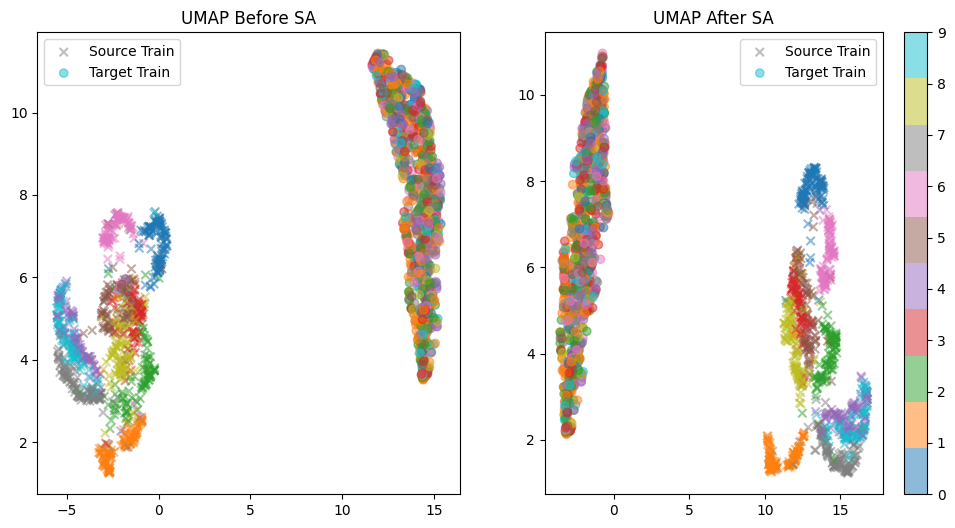

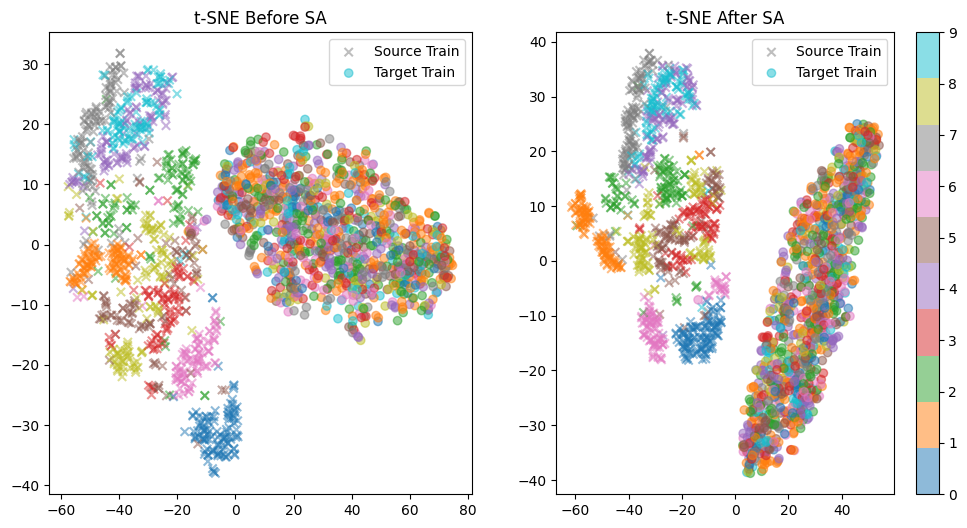

In [72]:
XTrainSp, XTestSp, XTrainTp, XTestTp = SA(XtrainS, XtestS, XtrainT, XtestT, d=100)

# Call the function with your train data and labels
plot_umap_tsne(XtrainS, XtrainT, XTrainSp, XTrainTp, ytrainS, ytrainT)

In [73]:
# Source domain
XtrainS = MNIST_Xtrain
ytrainS = MNIST_ytrain
XtestS = MNIST_Xtest
ytestS = MNIST_ytest

# Target domain
XtrainT = SVHN_Xtrain
ytrainT = SVHN_ytrain
XtestT = SVHN_Xtest
ytestT = SVHN_ytest

Ns=1000 # number of samples in source domain
Nt=1000 # number of samples in target domain

In [74]:
np.random.seed(42)
svm_clf = SVC(kernel='linear')
svm_clf.fit(XtrainS, ytrainS)
y_predT = svm_clf.predict(XtestT)
accuracy = accuracy_score(ytestT, y_predT)
print(f"Accuracy of classifier on target domain (without adaptation): {accuracy:.4f}")

Accuracy of classifier on target domain (without adaptation): 0.1580


In [75]:
np.random.seed(42)
for d in [10, 20, 30, 50, 100, 200]:
  svm_clf_pca = SVC(kernel='linear')
  pca = PCA(n_components=d)
  XtrainS_pca = pca.fit_transform(XtrainS)
  XtestT_pca = pca.transform(XtestT)
  svm_clf_pca.fit(XtrainS_pca, ytrainS)
  y_predT_pca = svm_clf_pca.predict(XtestT_pca)
  accuracy_pca = accuracy_score(ytestT, y_predT_pca)
  print(f"Accuracy with PCA (d={d}): {accuracy_pca:.4f}")

Accuracy with PCA (d=10): 0.1135
Accuracy with PCA (d=20): 0.1330
Accuracy with PCA (d=30): 0.1544
Accuracy with PCA (d=50): 0.1574
Accuracy with PCA (d=100): 0.1328
Accuracy with PCA (d=200): 0.1001


In [76]:
# Initialize best accuracy to track the best performing model
best_accuracy = 0
best_d = 0
best_model = None
best_method = ""

d_values = [10, 50, 100]

# Loop through different values of d to apply Subspace Alignment (SA)
for d in d_values:
    XTrainSp, XTestSp, XTrainTp, XTestTp = SA(XtrainS, XtestS, XtrainT, XtestT, d=d)

    # Train and evaluate using SVM with linear kernel
    accuracy_svm = svm_classifier(XTrainSp, ytrainS, XTestTp)

    # Train and evaluate using SVM with RBF kernel
    accuracy_svm_rbf = svm_rbf_classifier(XTrainSp, ytrainS, XTestTp)

    # Display results for current d
    print(f"Results for d={d}:")
    print(f"SVM (linear): {accuracy_svm:.4f}")
    print(f"SVM (RBF): {accuracy_svm_rbf:.4f}")
    print()

    # Track the best model
    if accuracy_svm > best_accuracy:
        best_accuracy = accuracy_svm
        best_d = d
        best_model = "SVM (linear)"


    if accuracy_svm_rbf > best_accuracy:
        best_accuracy = accuracy_svm_rbf
        best_d = d
        best_model = "SVM (RBF)"

# Output the best model and its performance
print(f"Best model: {best_model} with d={best_d}, Accuracy: {best_accuracy:.4f}")

Results for d=10:
SVM (linear): 0.1747
SVM (RBF): 0.1888

Results for d=50:
SVM (linear): 0.1636
SVM (RBF): 0.2012

Results for d=100:
SVM (linear): 0.0966
SVM (RBF): 0.1771

Best model: SVM (RBF) with d=50, Accuracy: 0.2012


## **Domain Adaptation Results**

### **1. MNIST → USPS Transfer**

#### **PCA Results:**
- The accuracy increases as the number of principal components (**d**) grows from **10 to 50**, peaking at **d = 50 (68.71%)**, and slightly decreasing beyond that.
- This suggests that **PCA helps retain important features** up to a certain dimensionality, after which **redundant or noisy features** might dilute the classifier's performance.

#### **Subspace Alignment (SA) Results:**
- The **RBF kernel SVM consistently outperforms** the linear SVM, with the best accuracy at **d = 100 (79.77%)**.
- This shows that **non-linear transformations** effectively capture complex relationships between the MNIST and USPS datasets, especially after **subspace alignment reduces the domain shift**.


### **2. MNIST → SVHN Transfer**

#### **Without Adaptation:**
- The accuracy is **extremely low (12.66%)**, highlighting a **significant domain shift** between handwritten digits (MNIST) and real-world images (SVHN).

#### **PCA Results:**
- The performance remains **poor across all dimensions**, with the highest accuracy being **12.85% for d = 100**.
- This suggests that **linear dimensionality reduction (PCA)** cannot effectively bridge the gap between the two domains.

#### **Subspace Alignment (SA) Results:**
- Despite SA, accuracies remain **low**, with the best being **11.96%** using a linear SVM at **d = 100**.
- Even the **neural network struggles**, barely exceeding **9% accuracy**. This indicates that the **feature mismatch** between MNIST and SVHN is **too large for simple alignment techniques** to handle.


### **3. SVHN → MNIST Transfer**

#### **Without Adaptation:**
- A baseline accuracy of **15.80%**, which is **slightly better than random guessing** but still poor.

#### **PCA Results:**
- The best accuracy of **15.74% at d = 50**, suggesting that **PCA provides minimal benefit** in this scenario.

#### **Subspace Alignment (SA) Results:**
- The **RBF kernel SVM again outperforms** the linear SVM, with the best result at **d = 50 (20.12%)**.
- However, the accuracy gains are **modest**, highlighting the **challenging nature of SVHN → MNIST adaptation** due to SVHN's **complex, real-world features**.


**Question**: What does it happen if you decrease the number of samples for the labeled training set? Is it expected based on the theory seen during the lecture ?

Reducing the number of labeled training samples generally leads to lower model accuracy due to limited data for learning, increasing the risk of overfitting. This aligns with the bias-variance trade-off, where fewer samples raise variance. Additionally, domain adaptation techniques like PCA and SA become less effective as the source representation becomes noisier, making it harder to align with the target domain. Regularization techniques become more important to maintain model generalization.







